# NBA Project Data Modeling
Notebook 3

## Purpose
This notebook focuses on building and evaluating a predictive model to identify key factors that influence NBA game attendance. The analysis involves several steps:

1. **Data Preprocessing:** Cleaning and preparing the dataset for modeling, including filtering out specific seasons and removing irrelevant or redundant features. Creating new features and reducing dimensionality to improve model performance.
3. **Model Development:** Implementing a Logistic Regression model to predict game attendance, using a pipeline approach with hyperparameter tuning.
4. **Model Evaluation:** Assessing the performance of the model through various metrics to determine its accuracy and predictive power.

The ultimate goal is to identify the most significant predictors of game attendance, providing insights that can inform strategic decisions within the NBA.

## Table of Contents
  - [Setup](#setup)
  - [Processing Data for Modeling](#processing-data-for-modeling)
    - [Preprocessing](#preprocessing)
    - [Dimensionality Reduction](#dimensionality-reduction)
  - [Identifying Attendance Predictors](#identifying-attendance-predictors)
    - [Logistic Regression Model](#implementing-logistic-regression-model)
    - [Evaluating Model](#evaluating-the-model)
    - [Findings](#findings)
  - [Summary](#summary)

## Setup

In [1]:
# Package Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
# Pandas Options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 1000)

In [3]:
# Specify the directory where you want to save the Visuals
save_dir = '../Visuals'
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist 

In [4]:
# Read combined NBA data saved from EDA notebook
combined_df = pd.read_csv('data/combined_data.csv')
combined_df.shape

(56323, 74)

## Processing Data for Modeling

### Preprocessing

##### Filtering Data Set

Note: Filtering out seasons that were identified during data analysis that may affect modeling

In [5]:
# Filtering data to exclude certain seasons
filtered_df = combined_df[
    (combined_df['season'] > 2000) &
    (combined_df['season'] != 2019) &
    (combined_df['season'] != 2020) &
    (combined_df['season'] != 2021) &
    (combined_df['season'] != 2012)
]
filtered_df.shape

(21932, 74)

In [6]:
# Drop rows where values are missing in column 'attendance' in place
filtered_df = filtered_df.dropna(subset=['attendance'])
filtered_df.shape

(21858, 74)

In [7]:
filtered_df.columns

Index(['game_id', 'team_id_home', 'team_id_away', 'full_name_home_team', 'full_name_away_team', 'wl_home', 'wl_away', 'game_date', 'day_of_week', 'month', 'game_duration', 'season_id', 'season', 'season_type', 'attendance', 'avg_attendance_home_team', 'above_avg_attendance', 'arenacapacity_home_team', 'attendance_ratio', 'near_sell_out', 'pts_home', 'pts_away', 'plus_minus_home', 'plus_minus_away', 'abbreviation_home_team', 'city_home_team', 'state_home_team', 'year_founded_home_team', 'arena_home_team', 'latitude_home_team', 'longitude_home_team', 'distance_miles', 'abbreviation_away_team', 'city_away_team', 'state_away_team', 'year_founded_away_team', 'latitude_away_team', 'longitude_away_team', 'season_w_home_team', 'season_l_home_team', 'wins_at_home_home_team', 'losses_at_home_home_team', 'away_wins_home_team', 'away_losses_home_team', 'games_this_season_home_team', 'games_at_home_home_team', 'away_games_home_team', 'total_pts_at_home_home_team', 'total_away_pts_home_team',
      

**Features to be Removed:** <br>

Data not relevant to attendance:
- year_founded_home_team
- year_founded_away_team
- game_id
- game_duration

Redundant Data:
- season_id
- attendance
- attendance_ratio
- near_sell_out
- plus_minus_away
- away_wins_home_team
- away_losses_home_team
- away_games_home_team
- away_pts_pg_home_team
- season_away_win_pct_home_team
- wins_at_home_away_team
- losses_at_home_away_team
- games_at_home_away_team
- total_pts_at_home_away_team
- pts_pg_at_home_away_team
- season_win_pct_at_home_away_team
- latitude_home_team
- longitude_home_team
- latitude_away_team
- longitude_away_team
- avg_attendance_home_team


Non-numerical data:
- full_name_home_team
- full_name_away_team
- game_date
- city_home_team
- state_home_team
- arena_home_team
- abbreviation_home_team
- city_away_team
- state_away_team
- abbreviation_away_team

In [8]:
# Selecting relevant features
features = ['team_id_home', 'team_id_away', 'wl_home', 'wl_away', 'distance_miles',
            'day_of_week', 'month', 'season', 'season_type',
            'above_avg_attendance', 'arenacapacity_home_team', 
            'pts_home', 'pts_away', 'plus_minus_home',
            'season_w_home_team', 'season_l_home_team', 'wins_at_home_home_team', 'losses_at_home_home_team', 'games_this_season_home_team', 'games_at_home_home_team', 'total_pts_at_home_home_team', 'total_away_pts_home_team', 'season_pts_pg_home_team','pts_pg_at_home_home_team', 'season_win_pct_home_team', 'season_win_pct_at_home_home_team', 
            'season_w_away_team', 'season_l_away_team', 'away_wins_away_team', 'away_losses_away_team', 'games_this_season_away_team', 'away_games_away_team', 'total_away_pts_away_team', 'season_pts_pg_away_team', 'away_pts_pg_away_team', 'season_win_pct_away_team', 'season_away_win_pct_away_team',  
            'prev_playoffs_home_team', 'prev_playoffs_away_team']

In [9]:
# Dropping irrelevant columns
filtered_df = filtered_df[features]
filtered_df.shape

(21858, 39)

##### Mapping Values

In [10]:
# Mapping numerical months to month names
month_mapping = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}
# Adding Month Name Column
filtered_df.loc[:, 'month_name'] = filtered_df['month'].map(month_mapping)
# Dropping associated month column
filtered_df = filtered_df.drop('month', axis=1)

##### One Hot Encoding
- wl_home
- season_type
- day_of_week
- month_name

In [11]:
wl_home_ohe = pd.get_dummies(filtered_df["wl_home"], dtype=int)
season_type_ohe = pd.get_dummies(filtered_df["season_type"], dtype=int)
day_of_week_ohe = pd.get_dummies(filtered_df["day_of_week"], dtype=int)
month_ohe = pd.get_dummies(filtered_df["month_name"], dtype=int)


Convert Booleans

In [12]:
filtered_df["prev_playoffs_home_team"] = filtered_df["prev_playoffs_home_team"].astype(int)
filtered_df["prev_playoffs_away_team"] = filtered_df["prev_playoffs_away_team"].astype(int)

##### Merging new features

In [13]:
to_concat = [filtered_df.select_dtypes("number"),
             wl_home_ohe.add_prefix("result_home_"),
             day_of_week_ohe.add_prefix("day_of_week_"),
             month_ohe.add_prefix("month_")]

In [14]:
correlation_df = pd.concat(to_concat, axis=1)
correlation_df.shape

(21858, 53)

### Dimensionality Reduction
Correlation Analysis: 
- Calculate correlations between different features to identify strong relationships.
- Removing highly correlated features

##### Identifying Multicollinearity 

In [15]:
# Calculating the correlation matrix and saving it to a data frame
correlation_matrix = correlation_df.corr()

In [16]:
# Filtering the correlation matrix to show only high correlations (|correlation coefficient| > 0.8)
threshold = 0.8

In [17]:
# Extracting pairs of highly correlated features
correlated_features = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            correlated_features.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

# Converting to DataFrame and sort by correlation
high_corr_df = pd.DataFrame(correlated_features)
high_corr_df = high_corr_df.sort_values(by='Correlation', ascending=False)

high_corr_df.shape

(32, 3)

##### Removing Highly Correlated Features

In [18]:
# Combining all features from both columns into a single list
features = list(high_corr_df['Feature 1']) + list(high_corr_df['Feature 2'])

# Counting occurrences of each feature
feature_counts = Counter(features)

# Extracting features that appear more than once
features_more_than_once = [feature for feature, count in feature_counts.items() if count > 1]

In [19]:
# Dropping the identified features from the dataset
data_reduced = correlation_df.drop(columns=features_more_than_once)
data_reduced.shape

(21858, 43)

In [20]:
# Recalculating the correlation matrix and saving it to a data frame
correlation_matrix = data_reduced.corr()

In [21]:
# Extracting remaining pairs of highly correlated features
correlated_features = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            correlated_features.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

# Converting to DataFrame and sort by correlation
high_corr_df = pd.DataFrame(correlated_features)
high_corr_df.shape

(8, 3)

In [22]:
high_corr_df.head(10)

,Feature 1,Feature 2,Correlation
0,wins_at_home_home_team,season_w_home_team,0.963698
1,losses_at_home_home_team,season_l_home_team,0.947708
2,pts_pg_at_home_home_team,season_pts_pg_home_team,0.965169
3,season_win_pct_at_home_home_team,season_win_pct_home_team,0.898761
4,away_wins_away_team,season_w_away_team,0.944279
5,away_losses_away_team,season_l_away_team,0.960716
6,away_pts_pg_away_team,season_pts_pg_away_team,0.965211
7,season_away_win_pct_away_team,season_win_pct_away_team,0.890059


In [23]:
features_to_remove = ['wins_at_home_home_team', 'losses_at_home_home_team', 'pts_pg_at_home_home_team', 
                      'season_win_pct_at_home_home_team', 'away_wins_away_team', 'away_losses_away_team', 
                      'away_pts_pg_away_team', 'season_away_win_pct_away_team']

In [24]:
# Dropping the identified features from the dataset
cleaned_data = data_reduced.drop(columns=features_to_remove)
cleaned_data.shape

(21858, 35)

In [25]:
# Uncomment to save cleaned data
#cleaned_data.to_csv('data/cleaned_data.csv', index=False)

## Identifying Attendance Predictors

#### Implementing Logistic Regression Model
- Using grid search to find optimal parameters to maximize accuracy
- Evaluate model performance by analyzing key metrics
- Identify top positive and negative predictors of above average game attendance

Splitting Dataset

In [26]:
X = cleaned_data.drop(columns=['above_avg_attendance'])
y = cleaned_data['above_avg_attendance']

# Splitting the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=25)

Defining the parameter grid

In [27]:
param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],  # Different scalers
    'logistic_regression__C': np.logspace(-3, 3, 10),  # Controls the inverse of regularization strength. Smaller values specify stronger regularization.
    'logistic_regression__penalty': ['l1', 'l2'],  # Type of regularization: L1 (Lasso), L2 (Ridge)
    'logistic_regression__solver': ['liblinear', 'saga'],  # Solvers that support l1 penalties
    'logistic_regression__max_iter': [1000]  # Iteration limit for all configurations
}

Creating a pipeline to include the scaler and logistic regression

In [28]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Initial scaler, will be overridden by GridSearchCV
    ('logistic_regression', LogisticRegression(random_state=25, solver='saga')) 
])

Training Logistic Regression Model

In [ ]:
# Initialize Grid Search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit Grid Search on the training data
grid_search.fit(X_train, y_train) 

# Extract the best model
best_model = grid_search.best_estimator_

#### Evaluating the Model

Accuracy

In [30]:
y_pred_best = best_model.predict(X_test)

# Evaluate the model performance
print("Best Parameters found by Grid Search:", grid_search.best_params_)
print("Accuracy of the best model:", accuracy_score(y_test, y_pred_best))

Best Parameters found by Grid Search: {'logistic_regression__C': 0.021544346900318832, 'logistic_regression__max_iter': 1000, 'logistic_regression__penalty': 'l1', 'logistic_regression__solver': 'saga', 'scaler': StandardScaler()}
Accuracy of the best model: 0.656907593778591


The model correctly predicts whether a game will have above-average attendance about 66% of the time. While not very high, it indicates that the model is better than random guessing

Confusion Matrix

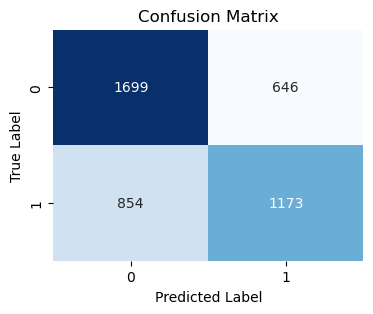

In [36]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Save visual
plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'))

plt.show()

The model has more True Negatives and True Positives than False Positives and False Negatives, which is good. However, the number of False Negatives (854) is relatively high, indicating that the model struggles more with predicting above-average attendance correctly.<br>

Classification Report

In [33]:
# Classification Report
class_report = classification_report(y_test, y_pred_best)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.72      0.69      2345
           1       0.64      0.58      0.61      2027

    accuracy                           0.66      4372
   macro avg       0.66      0.65      0.65      4372
weighted avg       0.66      0.66      0.65      4372



The model has a higher precision and recall for class 0 (below-average attendance) compared to class 1 (above-average attendance). This suggests the model is more conservative and tends to predict games as below-average attendance more often than not, potentially missing some games that would actually have above-average attendance.<br>

Macro Avg & Weighted Avg:
Both the macro and weighted averages are around 0.65, consistent with the accuracy. It confirms that the model's performance is relatively consistent across classes, but there’s room for improvement.

#### Findings

Extracting coefficients

In [34]:
log_reg = best_model.named_steps['logistic_regression']
coefficients = pd.DataFrame(log_reg.coef_.flatten(), index=X.columns, columns=['Coefficient'])
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

print("Top Positive Predictors:\n", coefficients.head(10))

Top Positive Predictors:
                          Coefficient
season_w_away_team          0.423785
day_of_week_Saturday        0.350248
day_of_week_Friday          0.294719
month_October               0.197018
month_April                 0.155200
month_March                 0.119865
season_l_home_team          0.075399
day_of_week_Sunday          0.055844
prev_playoffs_away_team     0.047045
pts_away                    0.024963


**Top Positive Predictors:**
- **season_w_away_team**:
  - As the number of wins for the away team in the season increases, the likelihood of above-average attendance increases. This suggests that stronger away teams draw more fans.

- **day_of_week_Saturday, Friday, Sunday**:
  - Games played on Saturdays & Sundays are more likely to have above-average attendance. This is likely because more people are available to attend games on weekends. Similarly, Fridays are also associated with higher attendance, likely due to the start of the weekend.

- **month_October, April, March**:
  - These months correspond to the start and end of the regular season and are associated with higher attendance.

- **season_l_home_team**:
  - Interestingly, the more losses the home team has in the season, the more likely it is to have above-average attendance. This could be interpreted as fans being more likely to attend games to support a struggling team, though this could also reflect some other underlying factor.

- **prev_playoffs_away_team**:
  - If the away team was in the playoffs the previous season, it slightly increases the chance of above-average attendance, possibly because of their perceived competitiveness or fan interest.

In [35]:
coefficients = coefficients.sort_values(by='Coefficient')
print("Top Negative Predictors:\n", coefficients.head(10))

Top Negative Predictors:
                        Coefficient
month_November           -0.198258
distance_miles           -0.138886
day_of_week_Tuesday      -0.127407
day_of_week_Monday       -0.125717
team_id_away             -0.124285
month_December           -0.108050
day_of_week_Wednesday    -0.095971
season                   -0.082144
month_January            -0.065824
team_id_home             -0.026817


**Top Negative Predictors:**
- **month_November, December, January**:
  - Games in November, December, and January are less likely to have above-average attendance, possibly due to competing holiday activities or the early stage of the season.

- **distance_miles**:
  - The greater the distance the away team has to travel, the less likely it is that the game will have above-average attendance. This could be due to the reduced interest in games with less well-known or local rival teams.

- **day_of_week_Wednesday, Monday, Tuesday**:
  - Games on these weekdays are less likely to have above-average attendance, likely because they are midweek and less convenient for fans to attend.

- **team_id_away, home**:
  - The specific ID of the teams playing negatively impacts attendance. This likely reflects the effect of certain less popular teams on drawing crowds. Might be worth exploring in the future to see which teams negatively affect attendance.

- **season**:
  - The specific season, has a negative impact on attendance, later seasons could have lower interest.


## Summary
- **Key Influencers**: The day of the week, the success of both the home and away teams, and the month of the game are key factors influencing attendance.
- **Potential Considerations**: Factors like distance and specific team IDs suggest some games are less attractive to fans, particularly those involving less competitive or geographically distant teams.

These insights can help guide strategies to boost attendance, such as scheduling key matchups on weekends or focusing marketing efforts on games with potentially lower draw due to timing or team dynamics.